In [9]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/data/tim/heronWorkspace/src")
sys.path.append("/data/tim/heronWorkspace/AE")
sys.path.append("/data/tim/heronWorkspace/classifier")


from AEHeronModelV1 import AEHeronModel
from AEHeronModelV2 import CAEHeron
from lightning.pytorch.callbacks import ModelSummary
from torchsummary import summary
import HeronImageLoader
from torch.utils.data import DataLoader, BatchSampler
from matplotlib import pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
import pandas as pd
from lightning.pytorch.loggers import CSVLogger
from MLPV1 import MLP, MLPMSEHeatMap
from models import MLPBasic, CAEBigBottleneck, CAESmallBottleneckWithLinear, MLPBasicHeatMap, CAEV1
import numpy as np
import torch.nn.functional as F
import torch
from torchvision.transforms import GaussianBlur
from PIL import Image, ImageFilter
import random
from scipy.stats import loguniform
from ClassifierDatasets import DatasetThreeConsecutive
# from torchmetrics.image import StructuralSimilarityIndexMeasure
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
sns.set_theme()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def applyFiltersAndPlot(imgs, preds, imds, vmin, vmax, lbl):
    f, a = plt.subplots(1,11, figsize=(110,10))

    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    preDiff = imds[1] - imds[0]
    nextDiff = imds[1] - imds[2]
   
    a[0].imshow(imgs[1])
    a[0].text(-0.5,0.5, f'True: {lbl}', size=100, ha="center", color = "red", transform=a[0].transAxes)
    a[0].text(0.5,-0.2, f'current Image', size=30, ha="center", transform=a[0].transAxes)

    a[1].imshow(preds[1])
    a[1].text(0.5,-0.4, f'prediction\nssim img to pred: {ssim(imgs[0], preds[0], channel_axis=2, data_range=1)}', size=30, ha="center", transform=a[1].transAxes)

    a[2].imshow(np.abs(imds[1]), cmap="hot", interpolation='none', norm=norm)
    a[2].text(0.5,-0.5, f'difference\nimd =|currImg - pred|\nssim prev imd to curr imd:\n{ssim(imds[0], imds[1], data_range=1)}', size=30, ha="center", transform=a[2].transAxes)

    a[3].imshow(np.abs(preDiff), cmap="hot", interpolation='none', norm=norm)
    a[3].text(0.5,-0.2, f'|Imd - ImdPrev|', size=30, ha="center", transform=a[3].transAxes)

    onlyPosDiffPred = np.where(preDiff < 0, 0, preDiff)

    a[4].imshow(onlyPosDiffPred, cmap="hot", interpolation='none', norm=norm)
    a[4].text(0.5,-0.4, f'(Imd - ImdPrev)\nonly Positives', size=30, ha="center", transform=a[4].transAxes)


    onlyPosDiffNext = np.where(nextDiff < 0, 0, nextDiff)

    posDiffPredAndNext = np.divide(np.add(onlyPosDiffPred, onlyPosDiffNext), 2.0)
    snr = np.mean(posDiffPredAndNext)/np.std(posDiffPredAndNext)
    a[5].imshow(posDiffPredAndNext, cmap = "hot", interpolation='none', norm=norm)
    a[5].text(0.5,-0.5, f'only Positives:\n((Imd - ImdPrev) + (Imd - ImdNext)\nsum: {np.sum(posDiffPredAndNext)}\nsnr: {snr}', size=30, ha="center", transform=a[5].transAxes)

    posDiffPredAndNextPil = Image.fromarray(np.uint8(posDiffPredAndNext * 255))
    
    normMinFilter = plt.Normalize(vmin=0, vmax=vmax/2)
    filtered = posDiffPredAndNextPil.filter(ImageFilter.MinFilter)
    a[6].imshow(np.array(filtered)/255, cmap = "hot", interpolation='none', norm=normMinFilter)
    a[6].text(0.5,-0.4, f'MinFilter\nsum: {np.sum(filtered)/255}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[6].transAxes)

    filtered = blur.forward(posDiffPredAndNextPil)
    a[7].imshow(np.array(filtered)/255, cmap = "hot", interpolation='none', norm=norm)
    a[7].text(0.5,-0.4, f'blurTorch\nsum: {np.sum(filtered)/255}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[7].transAxes)

    filtered = posDiffPredAndNextPil.filter(ImageFilter.SMOOTH)
    a[8].imshow(np.array(filtered)/255, cmap = "hot", interpolation='none', norm=norm)
    a[8].text(0.5,-0.4, f'smooth\nsum: {np.sum(filtered)/255}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[8].transAxes)

    filtered = posDiffPredAndNextPil.filter(ImageFilter.MedianFilter)
    a[9].imshow(np.array(filtered)/255, cmap = "hot", interpolation='none', norm=norm)
    a[9].text(0.5,-0.4, f'median\nsum: {np.sum(filtered)/255}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[9].transAxes)

    filtered = np.where(posDiffPredAndNext < np.max(posDiffPredAndNext) * 0.3, 0, posDiffPredAndNext)
    a[10].imshow(filtered, cmap = "hot", interpolation='none', norm=norm)
    a[10].text(0.5,-0.4, f'cutoff 0.3 * max\nsum: {np.sum(filtered)}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[10].transAxes)


    plt.show()

In [6]:
from matplotlib import rcParams
rcParams['patch.linewidth'] = 0.5

def applyFiltersAndPlotHist(imgs, preds, imds, vmin, vmax, lbl):
    f, a = plt.subplots(2,11, figsize=(110,20))

    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    preDiff = imds[1] - imds[0]
    nextDiff = imds[1] - imds[2]
   
    a[0][0].imshow(imgs[1])
    a[0][0].text(-0.5,0.5, f'True: {lbl}', size=100, ha="center", color = "red", transform=a[0][0].transAxes)
    a[0][0].text(0.5,-0.2, f'current Image', size=30, ha="center", transform=a[0][0].transAxes)

    a[0][1].imshow(preds[1])
    a[0][1].text(0.5,-0.4, f'prediction\nssim img to pred: {ssim(imgs[0], preds[0], channel_axis=2, data_range=1)}', size=30, ha="center", transform=a[0][1].transAxes)

    a[0][2].imshow(np.abs(imds[1]), cmap="hot", interpolation='none', norm=norm)
    a[0][2].text(0.5,-0.5, f'difference\nimd =|currImg - pred|\nssim prev imd to curr imd:\n{ssim(imds[0], imds[1], data_range=1)}', size=30, ha="center", transform=a[0][2].transAxes)

    a[0][3].imshow(np.abs(preDiff), cmap="hot", interpolation='none', norm=norm)
    a[0][3].text(0.5,-0.2, f'|Imd - ImdPrev|', size=30, ha="center", transform=a[0][3].transAxes)

    onlyPosDiffPred = np.where(preDiff < 0, 0, preDiff)

    a[0][4].imshow(onlyPosDiffPred, cmap="hot", interpolation='none', norm=norm)
    a[0][4].text(0.5,-0.4, f'(Imd - ImdPrev)\nonly Positives', size=30, ha="center", transform=a[0][4].transAxes)
    a[1][4].hist(onlyPosDiffPred.flatten(), bins=100)

    onlyPosDiffNext = np.where(nextDiff < 0, 0, nextDiff)

    posDiffPredAndNext = np.divide(np.add(onlyPosDiffPred, onlyPosDiffNext), 2.0)
    snr = np.mean(posDiffPredAndNext)/np.std(posDiffPredAndNext)
    a[0][5].imshow(posDiffPredAndNext, cmap = "hot", interpolation='none', norm=norm)
    a[0][5].text(0.5,-0.5, f'only Positives:\n((Imd - ImdPrev) + (Imd - ImdNext)\nsum: {np.sum(posDiffPredAndNext)}\nsnr: {snr}', size=30, ha="center", transform=a[0][5].transAxes)
    a[1][5].hist(posDiffPredAndNext.flatten(), bins=100)

    posDiffPredAndNextPil = Image.fromarray(np.uint8(posDiffPredAndNext * 255))
    
    filtered = posDiffPredAndNextPil.filter(ImageFilter.MinFilter)
    filtered = np.array(filtered)/255
    a[0][6].imshow(filtered, cmap = "hot", interpolation='none', norm=norm)
    a[0][6].text(0.5,-0.4, f'MinFilter\nsum: {np.sum(filtered)}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[0][6].transAxes)
    a[1][6].hist(filtered.flatten(), bins=100)

    filtered = blur.forward(posDiffPredAndNextPil)
    filtered = np.array(filtered)/255
    a[0][7].imshow(filtered, cmap = "hot", interpolation='none', norm=norm)
    a[0][7].text(0.5,-0.4, f'blurTorch\nsum: {np.sum(filtered)}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[0][7].transAxes)
    a[1][7].hist(filtered.flatten(), bins=100)

    filtered = posDiffPredAndNextPil.filter(ImageFilter.SMOOTH)
    filtered = np.array(filtered)/255
    a[0][8].imshow(filtered, cmap = "hot", interpolation='none', norm=norm)
    a[0][8].text(0.5,-0.4, f'smooth\nsum: {np.sum(filtered)}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[0][8].transAxes)
    a[1][8].hist(filtered.flatten(), bins=100)

    filtered = posDiffPredAndNextPil.filter(ImageFilter.MedianFilter)
    filtered = np.array(filtered)/255
    a[0][9].imshow(filtered, cmap = "hot", interpolation='none', norm=norm)
    a[0][9].text(0.5,-0.4, f'median\nsum: {np.sum(filtered)}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[0][9].transAxes)
    a[1][9].hist(filtered.flatten(), bins=100)
    
    filtered = posDiffPredAndNextPil.filter(ImageFilter.MinFilter)
    filtered = np.array(filtered)/255
    filtered = np.where(posDiffPredAndNext < 0.2, 0, posDiffPredAndNext)
    normMinFilter = plt.Normalize(vmin=0, vmax=vmax/2)
    a[0][10].imshow(filtered, cmap = "hot", interpolation='none', norm=normMinFilter)
    a[0][10].text(0.5,-0.4, f'cutoff 0.3 * max von minFilter\nsum: {np.sum(filtered)}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[0][10].transAxes)
    a[1][10].hist(filtered.flatten(), bins=100)

    for i in range(0, 10):
        # a[1][i].set_yscale('log')
        a[1][i].set_ylim([0,250])
        a[1][i].set_xlim([0,1])
       
        # a[1][i].set_xlim([0,100])
    a[1][10].set_xlim([0.01, 0.7])
    a[1][10].set_ylim([0,100])

    for i in range(0, 11):
        a[0, i].grid(False)
    plt.show()

In [7]:
def heatMap(before: torch.Tensor, after: torch.Tensor, stepY, stepX, loss_fn = F.mse_loss):
    heatMap = []
    for i in range(0, before.shape[-2]-stepY+1, stepY):
        row = []
        for j in range(0, before.shape[-1]-stepX+1, stepX):
            row.append(loss_fn(before[:, i:i+stepY, j:j+stepX], after[:, i:i+stepY, j:j+stepX]).item())
        heatMap.append(row)
    return torch.tensor(heatMap).type_as(before)

"batch_size":         16
"bottleneck":         128
"cameras":            ['NEN1', 'SBU3']
"gammaScheduler":     0.7879353477950641
"ldim":               16
"learning_rate":      0.003533238255084643
"num_workers_loader": 4
"transforms":         None
"weight_decay":       4.5387898639621974e-07
Length Dataset: 4
vmin: 0, vmax: 0.5
Start Loop
Non-Filtered Inputs:
Filtered Inputs:
L1:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_3415280/2625134213.py:70: RuntimeWarning: invalid value encountered in scalar divide
  a[0][10].text(0.5,-0.4, f'cutoff 0.3 * max von minFilter\nsum: {np.sum(filtered)}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[0][10].transAxes)


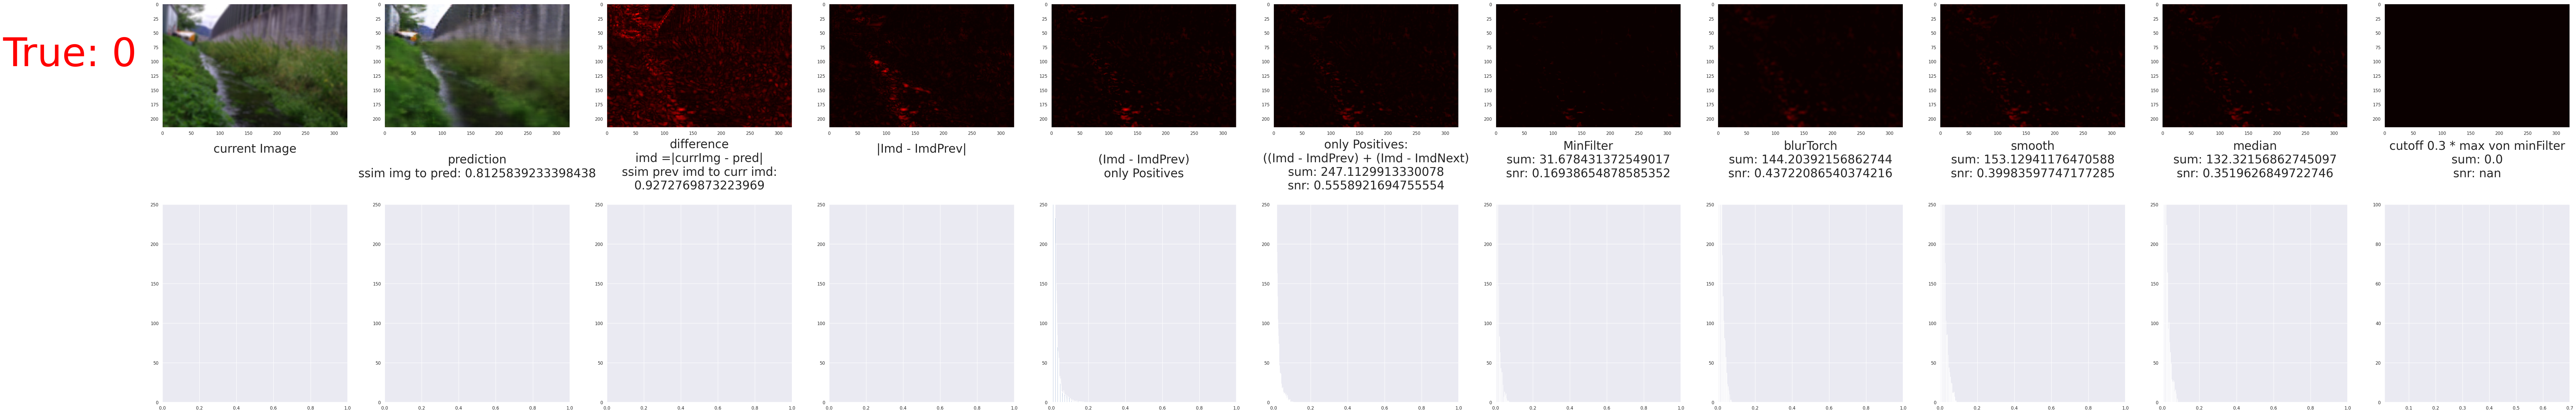

Non-Filtered Inputs:
Filtered Inputs:
L1:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


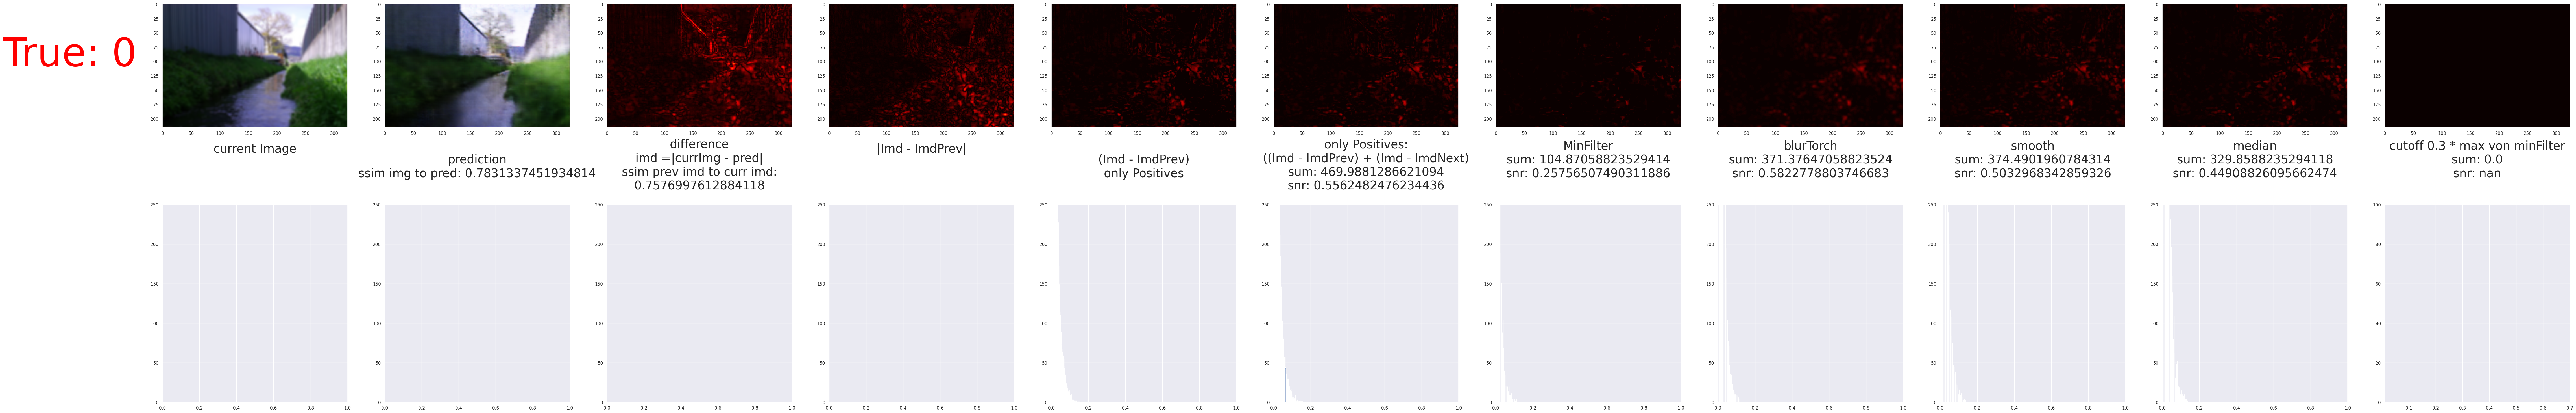

Non-Filtered Inputs:
Filtered Inputs:
L1:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


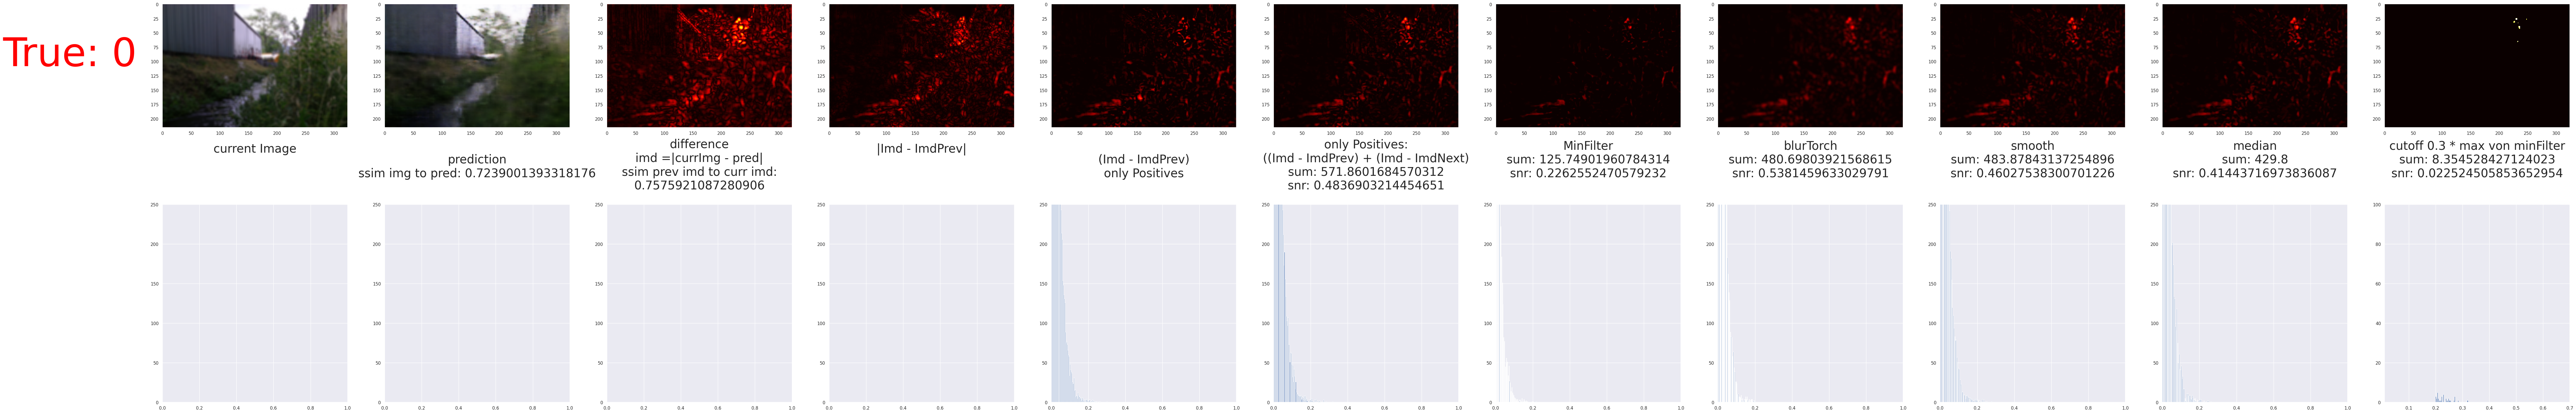

Non-Filtered Inputs:
Filtered Inputs:
L1:


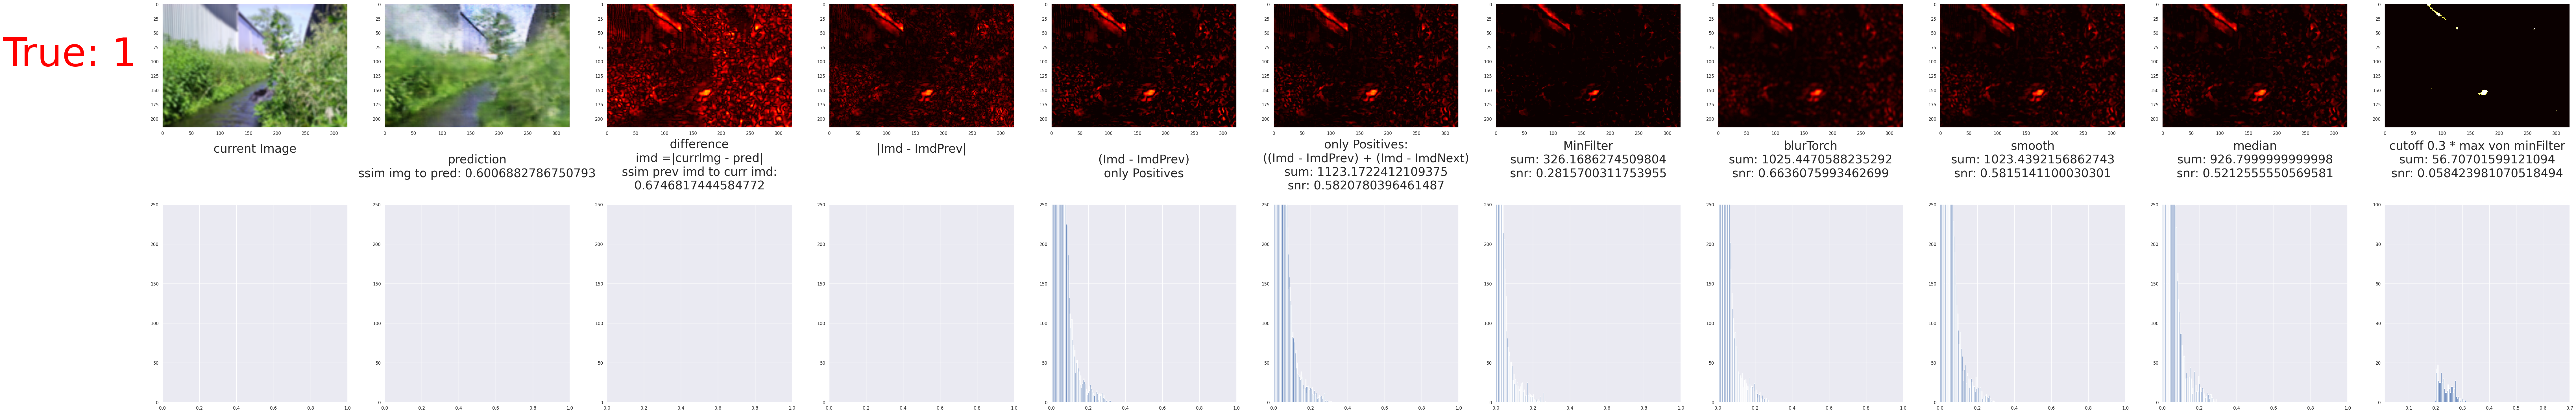

In [11]:
checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = CAEV1)
caeLoaded.freeze()
print(caeLoaded.hparams)

dataset = DatasetThreeConsecutive(set="test", resize_to=CAEV1.imsize, cameras=caeLoaded.hparams.cameras)
dataLoader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)
print(f'Length Dataset: {len(dataLoader.dataset.imagePaths)}')
unnorm = HeronImageLoader.UnNormalize()


stepY = 1
stepX = 1

blur = GaussianBlur(kernel_size=5, sigma=3)
# ssim = StructuralSimilarityIndexMeasure(reduction="none")

vmin = 0
vmax = 0.5
print(f"vmin: {vmin}, vmax: {vmax}")

print("Start Loop")

for i, (imArr, lblArr, _, _) in enumerate(dataLoader):
    lbl = lblArr[0].item()
    imgs = [x.to(caeLoaded.device) for x in imArr] #three consecutive images

    preds = [caeLoaded(x) for x in imgs] #imgs are already of shape (1, 3, 215, 323)
    
    # print(preds)

    imgsTorch = [unnorm(x.squeeze(0)) for x in imgs]
    predsTorch = [unnorm(x.squeeze(0)) for x in preds]

    imdsL1 = [heatMap(img, pred, stepY, stepX, loss_fn = F.l1_loss) for img, pred in zip(imgsTorch, predsTorch)]
    imdsMSE = [heatMap(img, pred, stepY, stepX, loss_fn = F.mse_loss) for img, pred in zip(imgsTorch, predsTorch)]

    imgs = [x.permute(1, 2, 0).cpu().numpy() for x in imgsTorch]
    preds = [x.permute(1, 2, 0).cpu().numpy() for x in predsTorch]
    imdsL1 = [x.cpu().numpy() for x in imdsL1]
    imdsMSE = [x.cpu().numpy() for x in imdsMSE]

    print("Non-Filtered Inputs:")

    # print("L1:")
    # applyFiltersAndPlotHist(imgs, preds, imdsL1, vmin, vmax, lbl)
    # print("MSE:")
    # applyFiltersAndPlotHist(imgs, preds, imdsMSE, vmin, vmax, lbl)

    print("Filtered Inputs:")
    blurredImgs = [blur.forward(x) for x in imgsTorch]

    blurredImdsL1 = [heatMap(img, pred, stepY, stepX, loss_fn = F.l1_loss) for img, pred in zip(blurredImgs, predsTorch)]
    blurredImdsMSE = [heatMap(img, pred, stepY, stepX, loss_fn = F.mse_loss) for img, pred in zip(blurredImgs, predsTorch)]
    blurredImdsL1 = [x.cpu().numpy() for x in blurredImdsL1]
    blurredImdsMSE = [x.cpu().numpy() for x in blurredImdsMSE]

    blurredImgs = [x.permute(1, 2, 0).cpu().numpy() for x in blurredImgs]

    print("L1:")
    applyFiltersAndPlotHist(blurredImgs, preds, blurredImdsL1, vmin, vmax, lbl)
    # print("MSE:")
    # applyFiltersAndPlotHist(blurredImgs, preds, blurredImdsMSE, vmin, vmax, lbl)

    
    if (i > 10):
        break
